# Climate-Friendly Food Systems (CFFS) Labelling Project

### The University of British Columbia

***

## Part V: Labelling Recipes

## Set up and Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import os
from configparser import ConfigParser

In [2]:
# RUN ONLY ONCE
# os.chdir is used to change the current directory to the specified path
os.chdir("../") # Sets path to the repo folder as it is one level above where this file exists!
path = os.getcwd()
print(path)

/Users/vivaanwadhwa/Documents/GitHub/CFFS_sharon_2024


## Set Baselines

In [3]:
config = ConfigParser()
config.read("data/Misc/data_for_calculating_baseline/baseline.ini")

overall_baseline = float(config["baseline"]["GHG_baseline"])
fifty_cutoff = overall_baseline/2

GHG_baseline = float(config["baseline"]["GHG_baseline"])
nitrogen_baseline = float(config["baseline"]["nitrogen_baseline"])
water_baseline = float(config["baseline"]["water_baseline"])
land_baseline = float(config["baseline"]["land_baseline"])
print(GHG_baseline,nitrogen_baseline,water_baseline,land_baseline)

364.61114734025256 4.428944853430558 1320.569404551064 0.8534548672606304


In [4]:
restaurant_name = "BlueChip_24"

In [5]:
def create_ghg_label(label):
    # determine the GHG label based on the given label value and predefined cutoffs
    if label > overall_baseline:
        # if the label value is > than overall baseline, assign "Red" label
        return "Red"
    elif (label <= overall_baseline) & (label > fifty_cutoff):
        # if the label value is between overall baseline and fifty_cutoff, assign "Yellow" label
        return "Yellow"
    elif label <= fifty_cutoff:
        # if the label value is less than or equal to the fifty_cutoff, assign "Green" label
        return "Green"


In [6]:
def create_results_all_factors(df):
    # create a Combined Label based on different factors for each row in the DataFrame
    df["Combined Label"] = ""

    # add another parameter: n so that change the number of factors instead of multiplying by 3

    def calculate_all_factors(ghg, nitrogen, water, land):
        # calculate the combined label value based on the given factors
        weighted_ghg = ghg / (4 * GHG_baseline)
        weighted_nitrogen = nitrogen / (4 * nitrogen_baseline)
        weighted_water = water / (4 * water_baseline)

        # most recently added
        weighted_land = land / (4 * land_baseline)
        return weighted_ghg + weighted_nitrogen + weighted_water + weighted_land


    for ind, row in df.iterrows():
        # iterate over each row in the DataFrame and calculate the combined label
        label = calculate_all_factors(row["GHG Emission (g) / 100g"], row["N lost (g) / 100g"],
                                      row["Stress-Weighted Water Use (L) / 100g"],
                                      row['Land Use (m^2) / 100g'])
        if label <= 0.5:
            # if the label value is less than or equal to 0.5, assign "Green" label
            df.loc[ind, "Combined Label"] = "Green"
        elif label >= 1:
            # if the label value is greater than or equal to 1, assign "Red" label
            df.loc[ind, "Combined Label"] = "Red"
        elif (label > 0.5) or (label < 1):
            # if the label value is between 0.5 and 1, assign "Yellow" label
            df.loc[ind, "Combined Label"] = "Yellow"
    return df


In [7]:
# Fixes KeyError: 1
def add_menu_names(df, mapping_dict):
    # Add menu names to the DataFrame based on a dictionary
    df["Displayed Name"] = ""
    menu_name = list(mapping_dict.keys())
    menu_ID = list(mapping_dict.values())
    for ind, row in df.iterrows():
        searchID = row["ProdId"]
        if searchID in menu_ID:
            position = menu_ID.index(searchID)
            name = menu_name[position]
            df.at[ind, "Displayed Name"] = name

    name_col = df.pop("Displayed Name")
    df.insert(0, "Displayed Name", name_col)
    df = df.dropna(subset=["Displayed Name"])

    df_temp = df["Displayed Name"].str.split("|", expand=True)
    df["Category"] = df_temp[0]

    # Ensure that 'Displayed Name' is updated only if there is a second column
    if len(df_temp.columns) > 1:
        df["Displayed Name"] = df_temp[1]
    else:
        df["Displayed Name"] = ""

    name_col2 = df.pop("Category")
    df.insert(0, "Category", name_col2)
    return df

In [8]:
def create_final_counts(df):
    # create final counts of GHG and combined labels from DataFrame

    # count the occurrences of GHG Only labels
    ghg_red = df["GHG Only Label"].value_counts()["Red"]
    ghg_yellow = df["GHG Only Label"].value_counts()["Yellow"]
    ghg_green = df["GHG Only Label"].value_counts()["Green"]
    # count the occurrences of Combined labels
    all_red = df["Combined Label"].value_counts()["Red"]
    all_yellow = df["Combined Label"].value_counts()["Yellow"]
    all_green = df["Combined Label"].value_counts()["Green"]
    print(all_red, all_yellow, all_green)
    # create a dictionary to store the label counts
    data = {"GHG Label Counts": [ghg_red, ghg_yellow, ghg_green],
            "Combined Label Counts": [all_red, all_yellow, all_green]}
    # create a DataFrame from the label counts data and return it
    results = pd.DataFrame(data, index=["Red", "Yellow", "Green"])
    return results


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

def create_visualizations(df):
    # Check if 'Color' column exists, if not, create it from the DataFrame's index
    if 'Color' not in df.columns:
        df = df.reset_index().rename(columns={'index': 'Color'})
    
    # Set the seaborn theme
    sns.set_theme(style="darkgrid")
    
    # Define the custom color palette
    palette = {"Green": "tab:green", "Red": "tab:red", "Yellow": "tab:orange", "Sum": "tab:blue"}
    
    # Create the subplot structure
    fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharex=False, sharey=True)
    
    # Overall figure title
    fig.suptitle("Emission Label Counts", fontsize=16)
    
    # Plotting GHG Emission Label counts
    ax1 = sns.barplot(data=df, x="Color", y="GHG Label Counts", ax=axes[0], palette=palette)
    ax1.set_title("GHG Emission Label")  # Set the title for the first plot
    ax1.set_ylabel("Counts")  # Set the Y-axis label for the first plot
    ax1.set_xlabel("Color")  # Optionally set the X-axis label
    
    # Plotting Combined Emissions Label counts
    ax2 = sns.barplot(data=df, x="Color", y="Combined Label Counts", ax=axes[1], palette=palette)
    ax2.set_title("Combined Emissions Label")  # Set the title for the second plot
    ax2.set_ylabel("")  # Optionally clear the Y-axis label for the second plot for aesthetics
    ax2.set_xlabel("Color")  # Optionally set the X-axis label
    
    # Add labels to the bars in both plots
    for ax in [ax1, ax2]:
        for container in ax.containers:
            ax.bar_label(container, label_type='edge')  # Add the counts above the bars
    
    # Adjust layout for a tight fit and to prevent label overlap
    plt.tight_layout()
    
    # Save the figure to file
    plt.savefig(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/AMS_Summary_fig.png")
    
    # Display the plot
    plt.show()


In [10]:
def create_category_true(df):
    # create category columns for True values in the DataFrame

    # create empty columns for each category
    df["RED"] = ""
    df["YELLOW"] = ""
    df["GREEN"] = ""
    # iterate over each row in the DataFrame
    for ind, row in df.iterrows():
        # Check the value of the Combined Label column and assign "TRUE" to the corresponding category column
        if row["Combined Label"] == "Red":
            df.loc[ind, "RED"] = "TRUE"
        if row["Combined Label"] == "Yellow":
            df.loc[ind, "YELLOW"] = "TRUE"
        if row["Combined Label"] == "Green":
            df.loc[ind, "GREEN"] = "TRUE"
    # adds category columns for True values based on the Combined Label column
    return df


In [11]:
products = pd.read_csv("data/final/AMS_2024_footprints/Recipes Footprints.csv")

In [12]:
final = products.copy()
final

,ProdId,Description,SalesGroup,Weight (g),GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g
0,R-4593,$garlic & onion,Y,50.000000,7802.796944,32.354278,8.720772,32.37,33897.73,15605.59,64.71,64.74,67795.46,17.44
1,R-3266,CHEDDAR SLICE,Y,21.000000,187.118399,1.959300,0.219660,32.75,1689.73,891.04,9.33,155.95,8046.33,1.05
2,R-9348,Cucumber,Y,30.150000,282.514545,0.203512,0.934650,0.75,6.64,937.03,0.68,2.49,22.02,3.10
3,R-9085,Lettuce,Y,28.350000,17.633700,0.223965,0.065205,1.55,70.40,62.20,0.79,5.47,248.32,0.23
4,R-2489,Tomato,Y,50.000000,48.670000,0.337500,0.087000,2.19,17.48,97.34,0.68,4.38,34.96,0.17
5,R-1771,Bagel - Jalapeno Cheddar,Y,100.000000,152.250000,1.480000,0.489000,41.92,1282.17,152.25,1.48,41.92,1282.17,0.49
6,R-2796,BC SMOKE SALMON,Y,265.000000,981.001500,7.652550,1.910400,138.56,3622.42,370.19,2.89,52.29,1366.95,0.72
7,R-3621,Four Cheese Melt,Y,301.000000,1027.338399,6.833500,1.920860,107.82,5806.13,341.31,2.27,35.82,1928.95,0.64
8,R-7916,Lite Crm Chz,Y,50.000000,445.520000,4.665000,0.523000,77.96,4023.16,891.04,9.33,155.92,8046.32,1.05
9,R-10771,MELT - TUNA,Y,290.000000,1118.455000,12.131000,2.151500,263.69,3937.11,385.67,4.18,90.93,1357.62,0.74


In [13]:
final["GHG Only Label"] = final["GHG Emission (g) / 100g"].apply(lambda x: create_ghg_label(x))
final

,ProdId,Description,SalesGroup,Weight (g),GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,GHG Only Label
0,R-4593,$garlic & onion,Y,50.000000,7802.796944,32.354278,8.720772,32.37,33897.73,15605.59,64.71,64.74,67795.46,17.44,Red
1,R-3266,CHEDDAR SLICE,Y,21.000000,187.118399,1.959300,0.219660,32.75,1689.73,891.04,9.33,155.95,8046.33,1.05,Red
2,R-9348,Cucumber,Y,30.150000,282.514545,0.203512,0.934650,0.75,6.64,937.03,0.68,2.49,22.02,3.10,Red
3,R-9085,Lettuce,Y,28.350000,17.633700,0.223965,0.065205,1.55,70.40,62.20,0.79,5.47,248.32,0.23,Green
4,R-2489,Tomato,Y,50.000000,48.670000,0.337500,0.087000,2.19,17.48,97.34,0.68,4.38,34.96,0.17,Green
5,R-1771,Bagel - Jalapeno Cheddar,Y,100.000000,152.250000,1.480000,0.489000,41.92,1282.17,152.25,1.48,41.92,1282.17,0.49,Green
6,R-2796,BC SMOKE SALMON,Y,265.000000,981.001500,7.652550,1.910400,138.56,3622.42,370.19,2.89,52.29,1366.95,0.72,Red
7,R-3621,Four Cheese Melt,Y,301.000000,1027.338399,6.833500,1.920860,107.82,5806.13,341.31,2.27,35.82,1928.95,0.64,Yellow
8,R-7916,Lite Crm Chz,Y,50.000000,445.520000,4.665000,0.523000,77.96,4023.16,891.04,9.33,155.92,8046.32,1.05,Red
9,R-10771,MELT - TUNA,Y,290.000000,1118.455000,12.131000,2.151500,263.69,3937.11,385.67,4.18,90.93,1357.62,0.74,Red


In [14]:
final = create_results_all_factors(final)
final

,ProdId,Description,SalesGroup,Weight (g),GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,GHG Only Label,Combined Label
0,R-4593,$garlic & onion,Y,50.000000,7802.796944,32.354278,8.720772,32.37,33897.73,15605.59,64.71,64.74,67795.46,17.44,Red,Red
1,R-3266,CHEDDAR SLICE,Y,21.000000,187.118399,1.959300,0.219660,32.75,1689.73,891.04,9.33,155.95,8046.33,1.05,Red,Red
2,R-9348,Cucumber,Y,30.150000,282.514545,0.203512,0.934650,0.75,6.64,937.03,0.68,2.49,22.02,3.10,Red,Red
3,R-9085,Lettuce,Y,28.350000,17.633700,0.223965,0.065205,1.55,70.40,62.20,0.79,5.47,248.32,0.23,Green,Green
4,R-2489,Tomato,Y,50.000000,48.670000,0.337500,0.087000,2.19,17.48,97.34,0.68,4.38,34.96,0.17,Green,Green
5,R-1771,Bagel - Jalapeno Cheddar,Y,100.000000,152.250000,1.480000,0.489000,41.92,1282.17,152.25,1.48,41.92,1282.17,0.49,Green,Yellow
6,R-2796,BC SMOKE SALMON,Y,265.000000,981.001500,7.652550,1.910400,138.56,3622.42,370.19,2.89,52.29,1366.95,0.72,Red,Yellow
7,R-3621,Four Cheese Melt,Y,301.000000,1027.338399,6.833500,1.920860,107.82,5806.13,341.31,2.27,35.82,1928.95,0.64,Yellow,Yellow
8,R-7916,Lite Crm Chz,Y,50.000000,445.520000,4.665000,0.523000,77.96,4023.16,891.04,9.33,155.92,8046.32,1.05,Red,Red
9,R-10771,MELT - TUNA,Y,290.000000,1118.455000,12.131000,2.151500,263.69,3937.11,385.67,4.18,90.93,1357.62,0.74,Red,Yellow


In [15]:
final.to_csv(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_"+restaurant_name+".csv", 
             index=False)
final.to_excel(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_"+restaurant_name+".xlsx", 
               sheet_name="Labels", index=False)

In [16]:
no_calcs = final.copy()
no_calcs = no_calcs.drop(columns=["GHG Emission (g) / 100g", "N lost (g) / 100g", "Stress-Weighted Water Use (L) / 100g", 'Land Use (m^2) / 100g',
                                  "GHG Emission (g)", "N lost (g)", "Stress-Weighted Water Use (L)", 'Land Use (m^2)', "SalesGroup","Weight (g)","Freshwater Withdrawals (L)","Freshwater Withdrawals (L) / 100g"
                                  ,"GHG Only Label"])
no_calcs.to_excel(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_No_Calcs_"+restaurant_name+".xlsx", 
                index=False)

In [17]:
# CHANGE THE NAME AS NEEDED AS PER THE RESTAURANT:

OK_list = final.set_index('Description')['ProdId'].to_dict()
OK_list

{'$garlic & onion': 'R-4593',
 'CHEDDAR SLICE': 'R-3266',
 'Cucumber': 'R-9348',
 'Lettuce': 'R-9085',
 'Tomato': 'R-2489',
 'Bagel - Jalapeno Cheddar': 'R-1771',
 'BC SMOKE SALMON': 'R-2796',
 'Four Cheese Melt': 'R-3621',
 'Lite Crm Chz': 'R-7916',
 'MELT - TUNA': 'R-10771',
 'Peanut Butter': 'R-2040',
 'Plain Crm Chz': 'R-7304',
 'TOASTED BAGEL': 'R-7252',
 'TUNA VEGGIE': 'R-10763',
 'TOMATO FOCACCIA': 'R-3646',
 'TSTD FOCCACIA': 'R-1009',
 '$SUB Almond milk': 'R-2049',
 '$SUB Oat Milk': 'R-6539',
 '$SUB Soy Milk': 'R-1344',
 'CHICK SALAD': 'R-6804',
 'EGG SALAD': 'R-7735',
 'EGG SALAD TOASTED': 'R-8651',
 'Ham & Cheese Cro': 'R-1887',
 'T-BIRD MUFFIN': 'R-1993',
 'Turkey & Cheddar': 'R-7596',
 'Vegan Falafel Wrap': 'R-2790',
 'Vegan T-Bird Muffin': 'R-5073',
 'WRAP - Asian Sesame Satay': 'R-4139',
 'WRAP - BACON': 'R-4116',
 'WRAP - CHICKEN QUINOA': 'R-9786',
 'WRAP - SALSA': 'R-8350',
 'WRAP - Vegan Medditerranean': 'R-3296',
 'BAGEL - Salmon Add on': 'R-12414'}

In [18]:
final2 = final.copy()
final2 = add_menu_names(final, OK_list)
final2.to_csv(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_"+restaurant_name+"_with_name.csv",
                  index=False)
final2.to_csv(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/Data_Labelled_"+restaurant_name+"_with_name.xlsx",
                  index=False)

In [19]:
counts = create_final_counts(final2)
all_ghg_num = counts["GHG Label Counts"].sum()
all_num = counts["Combined Label Counts"].sum()
sum_row = pd.Series(data={"GHG Label Counts": all_ghg_num, "Combined Label Counts": all_num}, name="Sum")

9 11 12


In [20]:
# counts = pd.concat([counts, sum_row], ignore_index=False)
# counts.to_csv(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/"+restaurant_name+"_Summary.csv", index=False)
# counts_print = pd.concat([counts, sum_row], ignore_index=True)
counts

,GHG Label Counts,Combined Label Counts
Red,11,9
Yellow,7,11
Green,15,12


Index(['GHG Label Counts', 'Combined Label Counts'], dtype='object')


/var/folders/bq/zkgc6_d969x_x5nsl5fy0vkh0000gn/T/ipykernel_31006/2886032372.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(data=df, x="Color", y="GHG Label Counts", ax=axes[0], palette=palette)
/var/folders/bq/zkgc6_d969x_x5nsl5fy0vkh0000gn/T/ipykernel_31006/2886032372.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(data=df, x="Color", y="Combined Label Counts", ax=axes[1], palette=palette)


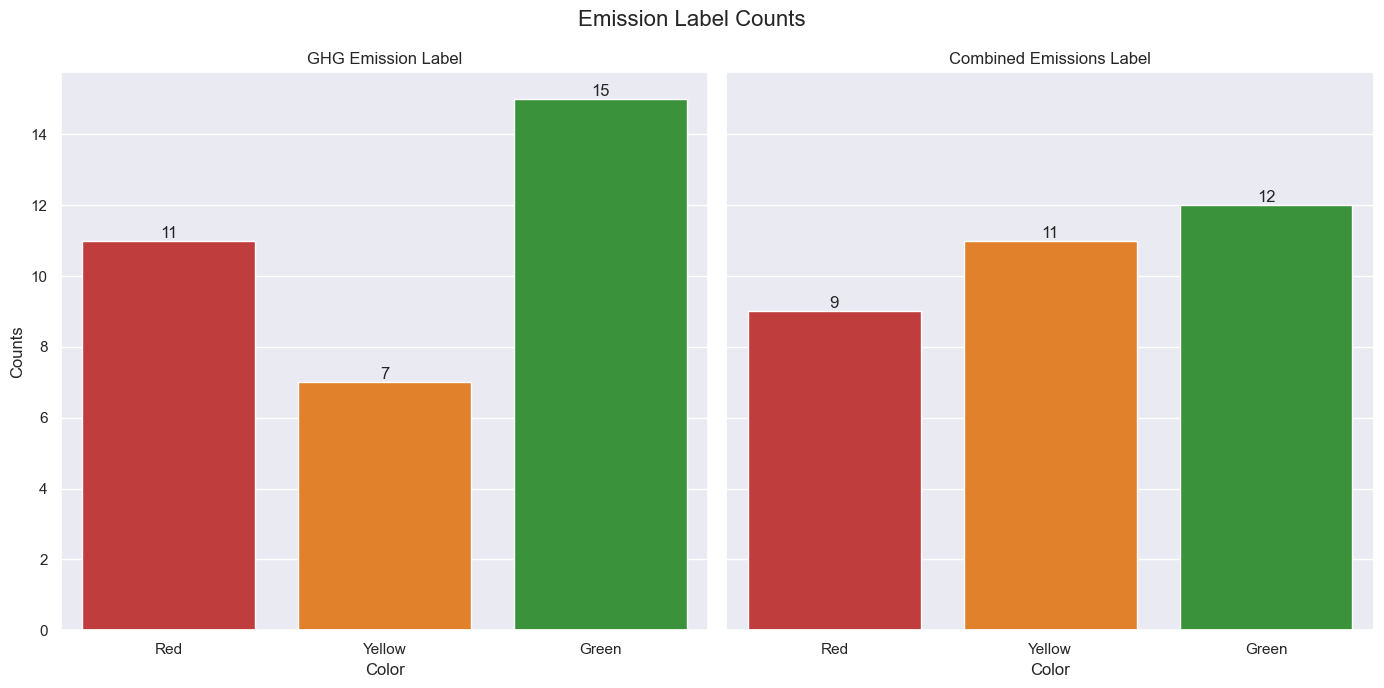

In [21]:
# THE BLUE BAR REPRESENTS THE SUM ROW WHICH IS THE TOTAL NUMBER OF RECIPES THAT HAVE BEEN ASSIGNED A LABEL
# EACH BAR REPRESENTS THE # OF RECIPES THAT WERE LABELLED WITH THAT SPECIFIC COLOUR

print(counts.columns)
fig = create_visualizations(counts)
fig

In [22]:
fig

In [23]:
final2.head()

,Category,Displayed Name,ProdId,Description,SalesGroup,Weight (g),GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,GHG Only Label,Combined Label
0,$garlic & onion,,R-4593,$garlic & onion,Y,50.00,7802.796944,32.354278,8.720772,32.37,33897.73,15605.59,64.71,64.74,67795.46,17.44,Red,Red
1,CHEDDAR SLICE,,R-3266,CHEDDAR SLICE,Y,21.00,187.118399,1.959300,0.219660,32.75,1689.73,891.04,9.33,155.95,8046.33,1.05,Red,Red
2,Cucumber,,R-9348,Cucumber,Y,30.15,282.514545,0.203512,0.934650,0.75,6.64,937.03,0.68,2.49,22.02,3.10,Red,Red
3,Lettuce,,R-9085,Lettuce,Y,28.35,17.633700,0.223965,0.065205,1.55,70.40,62.20,0.79,5.47,248.32,0.23,Green,Green
4,Tomato,,R-2489,Tomato,Y,50.00,48.670000,0.337500,0.087000,2.19,17.48,97.34,0.68,4.38,34.96,0.17,Green,Green


In [24]:
final3 = final2.drop(columns=['Category', 'Displayed Name', 'Weight (g)', 'GHG Only Label'])

In [25]:
final3.head()

,ProdId,Description,SalesGroup,GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,Combined Label
0,R-4593,$garlic & onion,Y,7802.796944,32.354278,8.720772,32.37,33897.73,15605.59,64.71,64.74,67795.46,17.44,Red
1,R-3266,CHEDDAR SLICE,Y,187.118399,1.959300,0.219660,32.75,1689.73,891.04,9.33,155.95,8046.33,1.05,Red
2,R-9348,Cucumber,Y,282.514545,0.203512,0.934650,0.75,6.64,937.03,0.68,2.49,22.02,3.10,Red
3,R-9085,Lettuce,Y,17.633700,0.223965,0.065205,1.55,70.40,62.20,0.79,5.47,248.32,0.23,Green
4,R-2489,Tomato,Y,48.670000,0.337500,0.087000,2.19,17.48,97.34,0.68,4.38,34.96,0.17,Green


In [26]:
final3.rename(columns={'ProdId': 'Optimum Control ID', 'Description': 'OC Description'}, inplace=True)

In [27]:
final3.head()

,Optimum Control ID,OC Description,SalesGroup,GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,Combined Label
0,R-4593,$garlic & onion,Y,7802.796944,32.354278,8.720772,32.37,33897.73,15605.59,64.71,64.74,67795.46,17.44,Red
1,R-3266,CHEDDAR SLICE,Y,187.118399,1.959300,0.219660,32.75,1689.73,891.04,9.33,155.95,8046.33,1.05,Red
2,R-9348,Cucumber,Y,282.514545,0.203512,0.934650,0.75,6.64,937.03,0.68,2.49,22.02,3.10,Red
3,R-9085,Lettuce,Y,17.633700,0.223965,0.065205,1.55,70.40,62.20,0.79,5.47,248.32,0.23,Green
4,R-2489,Tomato,Y,48.670000,0.337500,0.087000,2.19,17.48,97.34,0.68,4.38,34.96,0.17,Green


In [28]:
final3['Red'] = final3['Combined Label'] == 'Red'
final3['Yellow'] = final3['Combined Label'] == 'Yellow'
final3['Green'] = final3['Combined Label'] == 'Green'

In [29]:
final3.head()

,Optimum Control ID,OC Description,SalesGroup,GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g,Combined Label,Red,Yellow,Green
0,R-4593,$garlic & onion,Y,7802.796944,32.354278,8.720772,32.37,33897.73,15605.59,64.71,64.74,67795.46,17.44,Red,True,False,False
1,R-3266,CHEDDAR SLICE,Y,187.118399,1.959300,0.219660,32.75,1689.73,891.04,9.33,155.95,8046.33,1.05,Red,True,False,False
2,R-9348,Cucumber,Y,282.514545,0.203512,0.934650,0.75,6.64,937.03,0.68,2.49,22.02,3.10,Red,True,False,False
3,R-9085,Lettuce,Y,17.633700,0.223965,0.065205,1.55,70.40,62.20,0.79,5.47,248.32,0.23,Green,False,False,True
4,R-2489,Tomato,Y,48.670000,0.337500,0.087000,2.19,17.48,97.34,0.68,4.38,34.96,0.17,Green,False,False,True


In [30]:
desired_column_order = [
    'Optimum Control ID', 'OC Description', 'SalesGroup', 'Combined Label', 'Red', 'Yellow', 'Green',
    'GHG Emission (g)', 'N lost (g)', 'Land Use (m^2)', 'Freshwater Withdrawals (L)', 
    'Stress-Weighted Water Use (L)', 'GHG Emission (g) / 100g', 'N lost (g) / 100g', 
    'Freshwater Withdrawals (L) / 100g', 'Stress-Weighted Water Use (L) / 100g', 
    'Land Use (m^2) / 100g'
]

# Create a new DataFrame with the desired column order
data_reordered = final3[desired_column_order]

# Print the reordered DataFrame
data_reordered.head()


,Optimum Control ID,OC Description,SalesGroup,Combined Label,Red,Yellow,Green,GHG Emission (g),N lost (g),Land Use (m^2),Freshwater Withdrawals (L),Stress-Weighted Water Use (L),GHG Emission (g) / 100g,N lost (g) / 100g,Freshwater Withdrawals (L) / 100g,Stress-Weighted Water Use (L) / 100g,Land Use (m^2) / 100g
0,R-4593,$garlic & onion,Y,Red,True,False,False,7802.796944,32.354278,8.720772,32.37,33897.73,15605.59,64.71,64.74,67795.46,17.44
1,R-3266,CHEDDAR SLICE,Y,Red,True,False,False,187.118399,1.959300,0.219660,32.75,1689.73,891.04,9.33,155.95,8046.33,1.05
2,R-9348,Cucumber,Y,Red,True,False,False,282.514545,0.203512,0.934650,0.75,6.64,937.03,0.68,2.49,22.02,3.10
3,R-9085,Lettuce,Y,Green,False,False,True,17.633700,0.223965,0.065205,1.55,70.40,62.20,0.79,5.47,248.32,0.23
4,R-2489,Tomato,Y,Green,False,False,True,48.670000,0.337500,0.087000,2.19,17.48,97.34,0.68,4.38,34.96,0.17


In [31]:
data_reordered.to_csv(os.getcwd() + "/data/final/2023_2024_CFFS_Outcomes/Labelled_Data_"+restaurant_name+"_for_nutrislice.csv",
                  index=False)